# Advanced Econometrics (JEM217)– Home Assignment 2 (WS 2025)



**Authors: Sebastian Pasz, Vojtěch Dohnal, Tomáš Gabriel**

**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.  
We also set a fixed random seed (`set.seed(123)`) to ensure that all simulated results are fully reproducible.


In [3]:

req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr","glm2","gmm")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)
library(glm2)
library(gmm)

set.seed(123) 


Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'quantreg' was built under R version 4.4.3"
Loading required package: SparseM

Warning message:
"package 'SparseM' was built under R version 4.4.3"
Warning message:
"package 'lmtest' was built under R version 4.4.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.4.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'sandwich' was built under R version 4.4.3"
Warning message:
"package 'car' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.4.3"

Attaching package: 'car'


The following

## Problem 1 (a)
Simulating the $e_t$ process. And checking length of all 3 variables. We can see that all have length 1000.



In [5]:
T_full <- 1002                 # total length for e_t
e      <- rnorm(T_full, 0, 1)  # e_t ~ N(0,1)

e_t   <- e[3:T_full]           # t = 3..1002  -> length 1000
e_t_1 <- e[2:(T_full-1)]       # t-1
e_t_2 <- e[1:(T_full-2)]       # t-2

print(paste0(
  "Length e_t: ", length(e_t),
  ", t-1: ", length(e_t_1),
  ", t-2: ", length(e_t_2)
))

mu_true   <- 0
theta1_true <- 0.75
theta2_true <- 0.5
sigma2_true <- 1  # variance of e_t in DGP

y <- mu_true + e_t + theta1_true * e_t_1 + theta2_true * e_t_2
T <- length(y)
summary(y)

[1] "Length e_t: 1000, t-1: 1000, t-2: 1000"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.52537 -0.89595  0.06423  0.03472  0.92814  3.91749 

## (b)
Cheching ACF and PACF to see if the model is indeed MA(2)
From ACF we can see that the process looks MA(2) - because the first two lags values are very high (far from zero) and for lags <2 values are close to zero indicating that the proces is not of higher order.

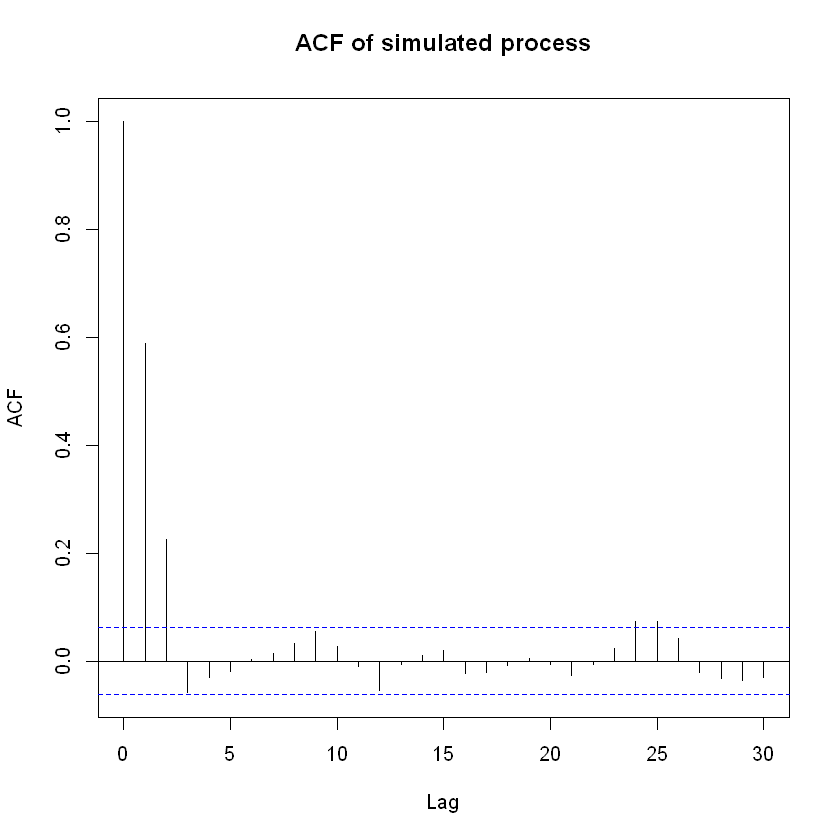

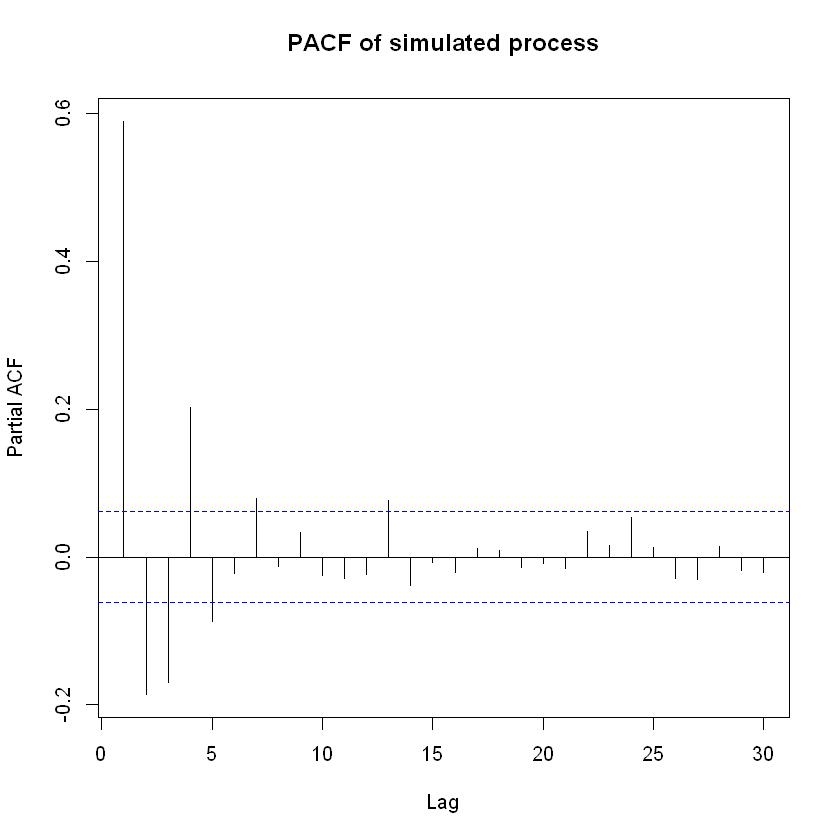

In [6]:
par(bg = "white")
acf(y, main = "ACF of simulated process")
pacf(y, main = "PACF of simulated process")

## (c)

Obtaining the moment conditions and creating a function to use them.


In [7]:
max_lag <- 4

y_lag0 <- y[(1+max_lag):T]
y_lag1 <- y[(1+max_lag-1):(T-1)]
y_lag2 <- y[(1+max_lag-2):(T-2)]
y_lag3 <- y[(1+max_lag-3):(T-3)]
y_lag4 <- y[(1+max_lag-4):(T-4)]

stopifnot(
  length(y_lag0) == length(y_lag1),
  length(y_lag0) == length(y_lag2),
  length(y_lag0) == length(y_lag3),
  length(y_lag0) == length(y_lag4)
)


data_gmm <- data.frame(
  y  = y_lag0,
  y1 = y_lag1,
  y2 = y_lag2,
  y3 = y_lag3,
  y4 = y_lag4
)


ma2_moments <- function(theta, data) {
  mu   <- theta[1]
  th1  <- theta[2]
  th2  <- theta[3]
  sig2 <- theta[4]

  yt <- data$y
  y1 <- data$y1
  y2 <- data$y2
  y3 <- data$y3
  y4 <- data$y4

  u  <- yt - mu
  u1 <- y1 - mu
  u2 <- y2 - mu
  u3 <- y3 - mu
  u4 <- y4 - mu

  gamma0 <- (1 + th1^2 + th2^2) * sig2
  gamma1 <- (th1 + th1 * th2)  * sig2
  gamma2 <- th2 * sig2
  gamma3 <- 0
  gamma4 <- 0

  m1 <- u                         # E[u_t] = 0
  m2 <- u^2    - gamma0           # Var
  m3 <- u*u1   - gamma1           # Cov lag 1
  m4 <- u*u2   - gamma2           # Cov lag 2
  m5 <- u*u3   - gamma3           # Cov lag 3
  m6 <- u*u4   - gamma4           # Cov lag 4

  cbind(m1, m2, m3, m4, m5, m6)
}


theta_start <- c(
  mu   = mean(y),
  th1  = 0.3,
  th2  = 0.2,
  sig2 = var(y) / 3
)

head(ma2_moments(theta_start, data_gmm))
summary(as.vector(ma2_moments(theta_start, data_gmm)))


m1,m2,m3,m4,m5,m6
1.77714271,2.5186330,3.01742616,1.53386433,1.93661421,1.90353535
-0.09655769,-0.6302798,-0.37536420,-0.28822158,-0.08949035,-0.10522228
-1.43990678,1.4337283,-0.06473333,-2.67212395,-2.60993022,-1.33451580
-1.62804833,2.0109381,2.14047043,0.04399648,-2.89327422,-2.95094974
0.51169279,-0.3777737,-1.03682799,-0.84999403,-0.04940787,0.90935111
1.02032808,0.4014662,0.31832712,-1.77434755,-1.46917733,-0.09852053


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8.0144 -0.5349  0.0406  0.3272  0.9376 14.4363 

## (d)

We estimate the MA(2) model by GMM under two configurations:

1. One-step GMM with **identity weighting matrix** (`wmatrix = "ident"`).
2. Two-step GMM with **optimal weighting matrix** (`wmatrix = "optimal"`).

The true DGP parameters are:
$
\mu = 0,\quad \theta_1 = 0.75,\quad \theta_2 = 0.5,\quad \sigma^2 = 1.
$

---

#### One-step GMM with identity weighting matrix


- $\mu$ is **not statistically significant** (p ≫ 0.05), which is consistent with the true mean of zero.
- $\theta_1$ and $\theta_2$ are **highly significant**, confirming the presence of MA(2) dynamics. $\theta_1$ is close to the true 0.75; $\theta_2$ is somewhat biased downward relative to 0.5.
- $\sigma^2$ is significantly different from zero and close to the true variance of 1.

J-test for overidentifying restrictions:

- J = 15.15, df = 2, p = 0.000513  
- We **reject** $H_0: E[g(\theta)] = 0$.  
  This indicates that, with the identity weighting matrix, the set of moment conditions is not jointly consistent with the data. In other words, the model plus chosen moments are rejected under this weighting scheme.

---

#### Two-step GMM with optimal weighting matrix

- $\mu$ remains **insignificant**, again consistent with a zero-mean process.
- $\theta_1$ and $\theta_2$ are **very precisely estimated** and now lie very close to their true values (0.75 and 0.5). Standard errors are lower than under the identity weighting, reflecting the efficiency gains of optimal GMM.
- $\sigma^2$ is almost exactly 1, matching the true innovation variance.

J-test for overidentifying restrictions:

- J = 2.45, df = 2, p = 0.293  
- We **do not reject** $H_0: E[g(\theta)] = 0$.  
  Under the optimal weighting matrix, the overidentifying restrictions are satisfied; the MA(2) specification and the chosen set of moments are jointly consistent with the data.


In [9]:


gmm_id <- gmm(
  g        = ma2_moments,
  x        = data_gmm,
  t0       = theta_start,
  wmatrix  = "ident",     
  type     = "twoStep"     
)

summary(gmm_id)
specTest(gmm_id)           # J-test


gmm_opt <- gmm(
  g        = ma2_moments,
  x        = data_gmm,
  t0       = coef(gmm_id), 
  wmatrix  = "optimal",
  type     = "twoStep"     
)

summary(gmm_opt)
specTest(gmm_opt)


Call:
gmm(g = ma2_moments, x = data_gmm, t0 = theta_start, type = "twoStep", 
    wmatrix = "ident")


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
      Estimate    Std. Error  t value     Pr(>|t|)  
mu    2.7810e-02  8.5086e-02  3.2685e-01  7.4378e-01
th1   7.0166e-01  3.6526e-02  1.9210e+01  3.0723e-82
th2   3.6612e-01  7.8457e-02  4.6665e+00  3.0630e-06
sig2  1.0433e+00  5.0127e-02  2.0812e+01  3.3498e-96

J-Test: degrees of freedom is 2 
                J-test      P-value   
Test E(g)=0:    1.5149e+01  5.1338e-04

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  227 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 2  ## 

                J-test      P-value   
Test E(g)=0:    1.5149e+01  5.1338e-04



Call:
gmm(g = ma2_moments, x = data_gmm, t0 = coef(gmm_id), type = "twoStep", 
    wmatrix = "optimal")


Method:  twoStep 

Kernel:  Quadratic Spectral(with bw =  3.01264 )

Coefficients:
      Estimate     Std. Error   t value      Pr(>|t|)   
mu     2.3244e-02   8.5012e-02   2.7342e-01   7.8453e-01
th1    7.3398e-01   3.2605e-02   2.2511e+01  3.2204e-112
th2    4.8504e-01   4.0229e-02   1.2057e+01   1.7814e-33
sig2   9.9261e-01   4.7231e-02   2.1016e+01   4.6526e-98

J-Test: degrees of freedom is 2 
                J-test   P-value
Test E(g)=0:    2.45317  0.29329

Initial values of the coefficients
        mu        th1        th2       sig2 
0.02772721 0.70168832 0.36612202 1.04318868 

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  251 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 2  ## 

                J-test   P-value
Test E(g)=0:    2.45317  0.29329
